# Chapter 5: Pretraining on Unlabeled Data

In [2]:
#import packages
from importlib.metadata import version

pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch",
        "tensorflow" # For OpenAI's pretrained weights
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.7
numpy version: 2.3.4
tiktoken version: 0.12.0
torch version: 2.9.0
tensorflow version: 2.20.0


## 5.1 Evaluating generative text models

### 5.1.1 Using GPT to generate text

Load and test previous chapter code

In [3]:
import torch
from previous_chapters import GPTModel
# If the `previous_chapters.py` file is not available locally,
# you can import it from the `llms-from-scratch` PyPI package.
# For details, see: https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg
# E.g.,
# from llms_from_scratch.ch04 import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

In [4]:
import tiktoken
from previous_chapters import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) #add batch dim out front
    return encoded_tensor

def token_ids_to_text(text, tokenizer):
    flat = text.squeeze(0) #squash batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


### 5.1.2 Manually calculating loss and perplexity

In [5]:
#load example text from book

inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [6]:
with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print(probas.shape)

token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

torch.Size([2, 3, 50257])
Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [7]:
#print outputs and targets as tokens
print(f"Targets batch 1: {token_ids_to_text(targets[0],tokenizer)}")
print(f"Targets batch 1: {token_ids_to_text(token_ids[0].flatten(),tokenizer)}")

Targets batch 1:  effort moves you
Targets batch 1:  Armed heNetflix


In [8]:
text_idx = 0
#batch 0, all three tokens, of the 50,000 vector, only look at the elements corresponding to the indices of the three targets
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]] 
print("Text 1:", target_probas_1)

text_idx = 1
#batch 0, all three tokens, of the 50,000 vector, only look at the elements corresponding to the indices of the three targets
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]] 
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


Suppressing the batch index. If the output of the model is $\vec{y}_{i}$ where the vector is over the classess (words in vocab) and the index $i$ denotes the sequence element, then the probability vector over the classes is
$$
\vec{p}_{i} = \text{Softmax}(\vec{y}_{i})
$$
The target is a one-hot vector whose elements are zero except one in the index corresponding to that tokens ID in the vocabulary, $\hat{e}_{i}$.

Then we compute the "negative average log probability as"
$$
\mathcal{L}= - \frac{1}{N_{\text{seq}}} \sum_{i}^{N_{\text{seq}}} \ln (\vec{p}_i \cdot \hat{e}_i)
$$


In [9]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])
tensor(-10.7940)
tensor(10.7940)


In [10]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

#flattening over batch dim
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])
Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])
tensor(10.7940)


$$\text{Perplexity} = 
\exp{\left\{ - \frac{1}{N_{\text{seq}}} \sum_{i}^{N_{\text{seq}}} \ln (\vec{p}_i \cdot \hat{e}_i)\right\}}
= \prod _{i}^{N_{\text{seq}}} \left(\vec{p}_i \cdot \hat{e}_i\right)^{- \frac{1}{N_{\text{seq}}}}
$$

In [11]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


### 5.1.3 Loss for training and validation sets

Get simple text file like in previous examples

In [12]:
import os
import requests

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    response = requests.get(url, timeout=30)
    response.raise_for_status()
    text_data = response.text
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)


Characters: 20479
Tokens: 5145


Creating dataloader using previous chapters

In [13]:
from previous_chapters import create_dataloader_v1

train_ratio = 0.9
split_idx = int(train_ratio*len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print(f"Not enough tokens for training loader. Increase training ratio, currently {train_ratio}")

if total_tokens * (1 - train_ratio) < GPT_CONFIG_124M["context_length"]:
    print(f"Not enough tokens for validation loader. Decrease training ratio, currently {train_ratio}")

In [14]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape,y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape,y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [15]:
train_tokens = 0
for input_batch, _ in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, _ in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


In [16]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss
        else:
            break
    return total_loss / num_batches

In [17]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
   device = torch.device("cuda")
elif torch.backends.mps.is_available():
   device = torch.device("mps")
else:
   device = torch.device("cpu")

print(f"Using {device} device.")


model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Using mps device.
Training loss: tensor(10.9876, device='mps:0')
Validation loss: tensor(10.9811, device='mps:0')


## 5.2 Training the LLM

In [18]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    #finally, the main training loop!
    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() #zero-out gradients 
            loss = calc_loss_batch(input_batch,target_batch,model,device) #compute loss
            loss.backward() #backprop
            optimizer.step() #update weights
            tokens_seen += input_batch.numel()
            global_step += 1
        
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"epoch {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen
    
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss
    
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n"," "))
    model.train()

In [19]:
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"\nTraining completed in {execution_time_minutes:.2f} minutes.")

epoch 1 (Step 000000): Train loss 9.817, Val loss 9.924
epoch 1 (Step 000005): Train loss 7.919, Val loss 8.332
Every effort moves you,,,,,,,,,,,,.                                     
epoch 2 (Step 000010): Train loss 6.582, Val loss 7.035
epoch 2 (Step 000015): Train loss 5.983, Val loss 6.588
Every effort moves you, the, the of the, the, the, the. ", the, the,,, the, and, the, of the, the, the, the, the, the, the, and, the,, the,
epoch 3 (Step 000020): Train loss 16.104, Val loss 16.126
epoch 3 (Step 000025): Train loss 5.553, Val loss 6.445
Every effort moves you. Gis. Gis. Gis. Gis. G. I had, and--, and, and, and--I. I had. I had to the his--. I had. I had been. Gis. I
epoch 4 (Step 000030): Train loss 5.041, Val loss 6.311
epoch 4 (Step 000035): Train loss 4.519, Val loss 6.212
Every effort moves you, and I had been the picture--I was a--and it.          "I to the the, I had the picture, I had the picture to the, and I had to me, I
epoch 5 (Step 000040): Train loss 4.087, Val los

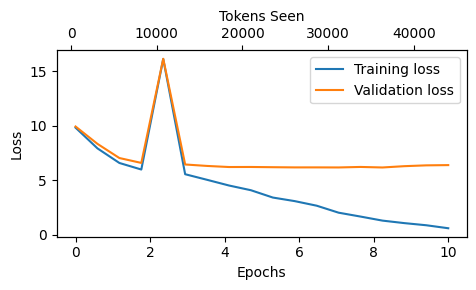

In [24]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    train_losses = [x.cpu().item() if torch.is_tensor(x) else x for x in train_losses]
    val_losses = [x.cpu().item() if torch.is_tensor(x) else x for x in val_losses]

    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens Seen")

    fig.tight_layout()
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0,num_epochs,len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## 5.3 Adding basic sampling strategies

In [28]:
inference_device = torch.device("cpu")

model.to(inference_device)
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids("Every effort moves you",tokenizer).to(inference_device),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




### 5.3.1 Temperature scaling

In [29]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# The next generated token is then as follows:
print(inverse_vocab[next_token_id])

forward


In [30]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


In [32]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sample_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    for i, freq in enumerate(sample_ids):
        print(f"{freq} x {inverse_vocab[i]}")
print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward
0 x you


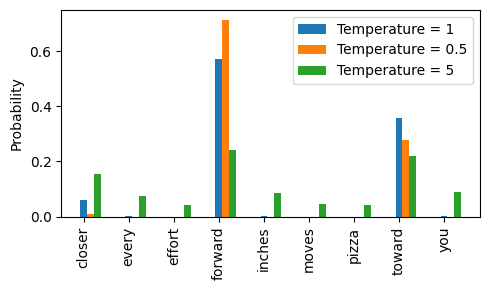

In [34]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits,dim=0)
temperatures = [1, 0.5, 5]

scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5,3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f"Temperature = {T}")

ax.set_ylabel("Probability")
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

In [35]:
print_sampled_tokens(scaled_probas[1])

4 x closer
0 x every
0 x effort
732 x forward
0 x inches
0 x moves
0 x pizza
264 x toward
0 x you


In [36]:
print_sampled_tokens(scaled_probas[2])

165 x closer
75 x every
42 x effort
239 x forward
71 x inches
46 x moves
32 x pizza
227 x toward
103 x you


### 5.3.2 Top-k sampling

In [38]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions", top_pos)

new_logits = torch.where(
    condition = next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")),
    other=next_token_logits 
)
print(new_logits)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions tensor([3, 7, 0])
tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


### 5.3.3 New generation function

In [45]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:,-context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        #top-k sampling
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val,
                                 torch.tensor(float("-inf")).to(logits.device),
                                 logits
            )

        #apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature
            logits = logits - logits.max(dim=-1, keepdim=True).values
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)

        else: #original functionality
            idx_next = torch.argmax(probs, num_samples=1)

        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [52]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(inference_device),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves youlit to work on surprise. It is to have been the end of enough


## 5.4 Loading and saving models

In [55]:
torch.save(model.state_dict(),"model.pth")

In [56]:
model = GPTModel(GPT_CONFIG_124M)
device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth",map_location=device, weights_only=True))

<All keys matched successfully>

In [57]:
torch.save({
    "model_state_dict" : model.state_dict(),
    "optimizer_state_dict" : optimizer.state_dict(),
},
"model_and_optimizer.pth")